# DIVAnd Atlantic test

This notebook serves as a large test case with data covering the Atlantic region.

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using PhysOcean
using DataStructures
using PyPlot
using Dates
using Statistics
using Random
using Printf

┌ Info: Recompiling stale cache file /home/abarth/.julia/compiled/v1.0/DIVAnd.ji for DIVAnd [top-level]
└ @ Base loading.jl:1190


This notebook uses the module `DIVAnd`:
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1466985.svg)](https://doi.org/10.5281/zenodo.1466985)

## Data
The observations are taken from the [SeaDataCloud aggregated products](https://www.seadatanet.org/Products#/search?from=1&to=20), in this case the "North Atlantic Ocean - Temperature and salinity observation collection V2" (file identifier: a61129f0-afbc-4bfa-8307-00f37d37d98a).   

In [2]:
datadir = "SeaDataCloud"
datafile = joinpath(datadir, "data_from_SDN_2015-09_TS_Atlantic_QC_done_v2.nc")
smalldatanc = joinpath(datadir, "smallData.nc")
isfile(datafile)

true

Test the data reading on a small (2000 lines) file.

⌛⌛⌛ Read the whole data set... that will take a while (16-17 minutes in my case).

In [5]:
varname = "Salinity"

if !isfile(joinpath(datadir,"obs.nc"))
    @time obsval, obslon, obslat, obsdepth, obstime, obsid = NCODV.load(
        Float64,
        datafile, "Water body salinity");

    DIVAnd.saveobs(joinpath(datadir,"obs.nc"),varname,obsval,
                   (obslon, obslat, obsdepth, obstime),obsid)
else
    obsval,obslon, obslat, obsdepth, obstime,obsid = DIVAnd.loadobs(Float64,joinpath(datadir,"obs.nc"),varname)
end


0 out of 1439726 - 0.0 %
10000 out of 1439726 - 0.694576606937709 %
20000 out of 1439726 - 1.389153213875418 %
30000 out of 1439726 - 2.0837298208131267 %
40000 out of 1439726 - 2.778306427750836 %
50000 out of 1439726 - 3.472883034688545 %
60000 out of 1439726 - 4.1674596416262535 %
70000 out of 1439726 - 4.862036248563963 %
80000 out of 1439726 - 5.556612855501672 %
90000 out of 1439726 - 6.251189462439381 %
100000 out of 1439726 - 6.94576606937709 %
110000 out of 1439726 - 7.640342676314798 %
120000 out of 1439726 - 8.334919283252507 %
130000 out of 1439726 - 9.029495890190217 %
140000 out of 1439726 - 9.724072497127926 %
150000 out of 1439726 - 10.418649104065635 %
160000 out of 1439726 - 11.113225711003343 %
170000 out of 1439726 - 11.807802317941052 %
180000 out of 1439726 - 12.502378924878762 %
190000 out of 1439726 - 13.19695553181647 %
200000 out of 1439726 - 13.89153213875418 %
210000 out of 1439726 - 14.586108745691888 %
220000 out of 1439726 - 15.280685352629597 %
230000 ou

## Analysis configuration
* Define the horizontal (Δx, Δy), vertical (depthr) and temporal resolutions (yearlist, monthlist).    
* Select the variable
* Set the time periods

In [83]:
@show extrema(obslon);
@show extrema(obslat);
@show extrema(obstime);

extrema(obslon) = (-96.5830078125, -0.99749755859375)
extrema(obslat) = (9.779000282287598, 70.9800033569336)
extrema(obstime) = (1900-03-07T10:02:00, 2015-03-03T02:35:57)


In [7]:
Δx, Δy = 2.0, 2.0
lonr = -100.0:Δx:0.0
latr = 9.0:Δy:71.0
timerange = [Date(1900,1,1),Date(2015,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
#depthr = [0.,20.,50.];

In [8]:
# year and month-list for background analysis
yearlist = [1900:1989,1990:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);


TS = TimeSelectorYearListMonthList{Array{UnitRange{Int64},1},Array{Int64,1}}(UnitRange{Int64}[1900:2017], [1])


**⚠** here we have defined the grid with longitudes from -180 to 180°, while for the data they range from 0 to 360°, hence for consistency a transformation is necessary.

In [9]:
obslon[obslon.>180.] = obslon[obslon.>180.] .- 360.;
@show extrema(obslon);

extrema(obslon) = (-96.5830078125, -0.655181884765625)


### Data plot
For applications with a large number of data points it is advised to first apply the `unique` function to keep only one location per profile.

In [10]:
coords = [(x,y) for (x,y) in zip(obslon, obslat)];
coords_u = unique(coords);
@info "Total number of coordinates: $(length(coords))"
@info "Number of unique coordinates (profiles): $(length(coords_u))"

┌ Info: Total number of coordinates: 31852170
└ @ Main In[10]:3
┌ Info: Number of unique coordinates (profiles): 674546
└ @ Main In[10]:4


In [11]:
obslon_u = [x[1] for x in coords_u];
obslat_u = [x[2] for x in coords_u];

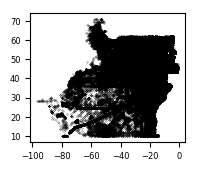

In [12]:
figure("Atlantic-Data")
ax = subplot(1,1,1)
plot(obslon_u, obslat_u, "ko", markersize=.2)
aspect_ratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
ax.set_aspect(aspect_ratio)

Check the extremal values of the observations

In [13]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/divand.jl/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (-96.5830078125, -0.655181884765625)
              minimum and maximum of obs. dimension 2: (9.779000282287598, 70.9800033569336)
              minimum and maximum of obs. dimension 3: (0.0, 6419.951171875)
              minimum and maximum of obs. dimension 4: (1900-03-07T10:02:00, 2015-03-03T02:35:57)
                          minimum and maximum of data: (0.0, 38.56999969482422)


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.      
Check [06-topography](./06-topography.ipynb) for details.

In [84]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")
# https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download  gebco_30sec_4.nc
# https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download  gebco_30sec_8.nc
# https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download  gebco_30sec_16.nc

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info "Bathymetry file already downloaded"
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[84]:9


Load the bathymetry

In [85]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  0.211483 seconds (298 allocations: 7.519 MiB, 98.52% gc time)


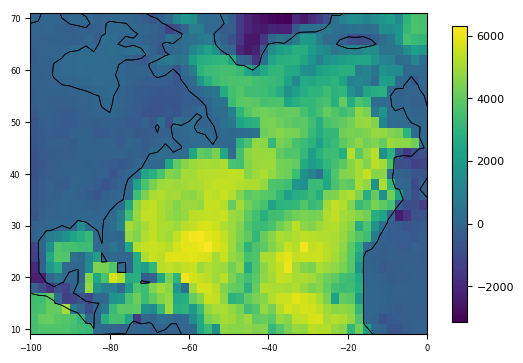

In [86]:
figure("Atlantic-Bathymetry")
ax = gca()
pcolor(bx,by,permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8)[:ax].tick_params(labelsize=8)
contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
ax.set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [ ]:
# surface mask
surfwater = b .>= depthr[1]
ax = gca()
figure("Atlantic-water")
ax.set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)
pcolor(bx,by,Float64.(surfwater'))


label = DIVAnd.floodfill(surfwater)
surfmask = label .== 1 # largest area has the label 1

In [87]:
figure("Atlantic-Mask")
ax = gca()
ax.set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)
pcolor(bx,by,Float64.(surfmask'))

mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = (b[i,j] >= depthr[k]) && surfmask[i,j]
        end
    end
end
@show size(mask)

size(mask) = (51, 32, 3)


(51, 32, 3)

## 3. Extract data from other sources
As an illustration we use the World Ocean Database, among other possibilities.

### 3.1 World Ocean Database

⌛⌛         
Read the data. This can also take up to a few minutes, depending on the size of the domain and remove duplicates 
⚠⚠ Only if you have more than one source of data. ⚠⚠    
Otherwise, go directly to section [4. Quality control](91-AtlanticTest.ipynb#4.-Quality-control)

⌛     
Criteria (can be adapted according to the application):
* Horizontal distance: 0.01 degree (about 1km)
* Vertical separation: 0.01 m depth
* Time separation: 1 minute.      
* Salinity difference:  0.01 psu.

In [ ]:
#=
email = "a.barth@uliege.be"
woddatadir = joinpath(datadir,"WOD")

if !isfile(joinpath(datadir,"obs-wod-combined.nc"))
    mkpath(woddatadir);

    WorldOceanDatabase.download(lonr,latr,timerange,varname,email,woddatadir);

    # 1977 is the EMDO code of the NOAA/NODC
    @time obsvalwod,obslonwod,obslatwod,obsdepthwod,obstimewod,obsidwod =
        WorldOceanDatabase.load(Float64,woddatadir,varname, prefixid = "1977-");

    @time dupl = DIVAnd.Quadtrees.checkduplicates(
        (obslon,obslat,obsdepth,obstime), obsval,
        (obslonwod,obslatwod, obsdepthwod, obstimewod), obsvalwod,
        (0.01,0.01,0.01,1/(24*60)),0.01);

    index = findall.(.!isempty.(dupl));
    ndupl = length(index);
    pcdupl = round(ndupl / length(obslon) * 100; digits=2);
    @info "Number of possible duplicates: $ndupl"
    @info "Percentage of duplicates: $pcdupl%"

    newpoints = isempty.(dupl);
    @info "Number of new points: " * string(sum(newpoints))

    obslon = [obslon; obslonwod[newpoints]];
    obslat = [obslat; obslatwod[newpoints]];
    obsdepth = [obsdepth; obsdepthwod[newpoints]];
    obstime = [obstime; obstimewod[newpoints]];
    obsval = [obsval; obsvalwod[newpoints]];
    obsid = [obsid; obsidwod[newpoints]];

    figure("Additional-Data")
    ax = subplot(1,1,1)
    ax.tick_params("both",labelsize=6)
    ylim(39.0, 46.0);
    xlim(11.5, 20.0);
    contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
        levels=[-1e5,0],cmap="binary");
    plot(obslon, obslat, "bo", markersize=.2, label="SeaDataNet")
    plot(obslonwod[newpoints], obslatwod[newpoints], "go",
        markersize=.2, label="Additional data\nfrom World Ocean Database")
    legend(loc=3, fontsize=4)
    ax.set_aspect(aspect_ratio)

    DIVAnd.saveobs(joinpath(datadir,"obs-wod-combined.nc"),varname,obsval,
                   (obslon, obslat, obsdepth, obstime),obsid)
else
    obsval,obslon, obslat, obsdepth, obstime,obsid = DIVAnd.loadobs(Float64,joinpath(datadir,"obs-wod-combined.nc"),varname)
end
=#

Create a plot showing the additional data points:

## 4. Quality control
We check the salinity value.     
This criteria has to be adapted to the region and the variable.    
If the QC has already been performed, this step can be skipped.

In [ ]:
sel = (obsval .<= 40) .& (obsval .>= 25);

In [ ]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

## 5. Analysis parameters

### 5.1 Data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

In [ ]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### 5.2 Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
⚠ With this function, the correlation length has to be defined in meters (not in degrees).     
For the first test, the correlation length is assumed to uniform over the domain and the depth levels.

In [ ]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(200_000.,sz)   # 200 km
leny = fill(200_000.,sz)   # 200 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lenbackground = (lenx, leny, lenz);
# determined by DIVAnd
len = (ones(sz),ones(sz),ones(sz))
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;



### Output file name

In [ ]:
filenamebackground = "Water_body_$(replace(varname," "=>"_"))_Atlantic_background.4Danl.nc"
filename = "Water_body_$(replace(varname," "=>"_"))_Atlantic.4Danl.nc"

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the [Sextant catalog](https://sextant.ifremer.fr/en).

In [ ]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "http://dx.doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

Create global and variable attributes:

In [ ]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr);

## 7. Analysis

If you already had an analysis, you have to 
* either remove the result file before running the analysis
* or modify the name of the output file, 

otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [ ]:
if isfile(filenamebackground)
    rm(filenamebackground) # delete the previous analysis
    @info "Removing file $filenamebackground"
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and each depth level.     
All the figures will be saved the selected directory.

In [ ]:
figdir = "./Atlantic/figures/"
if !isdir(figdir)
    mkpath(figdir);
    @info "Creating directory $(figdir)"
end
solver = :direct

In [ ]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Atlantic analysis")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(minimum(latr) - Δy, maximum(latr) + Δy);
        xlim(minimum(lonr) - Δx, maximum(lonr) + Δx);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-Δx/2.,latr.-Δy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 33, vmax = 40)
        colorbar(extend="both", orientation="vertical", shrink=0.8)[:ax].tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        ax.set_aspect(aspect_ratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=300, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [ ]:
# background analysis
dbinfo = @time diva3d((lonr,latr,depthr,TSbackground),
                      (obslon,obslat,obsdepth,obstime), obsval,
                      lenbackground, epsilon2,
                      filenamebackground,varname,
                      bathname=bathname,
                      mask = mask,
                      fitcorrlen = false,
                      ncvarattrib = ncvarattrib,
                      ncglobalattrib = ncglobalattrib,
                      solver = solver,
                      MEMTOFIT = 120,
                      );


In [ ]:
yearlist = [1970:1979,1980:1989,1990:1999,2000:2009];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

# analysis using background field

dbinfo = @time diva3d((lonr,latr,depthr,TS),
                      (obslon,obslat,obsdepth,obstime), obsval,
                      len, epsilon2,
                      filename,varname,
                      bathname=bathname,
                      #    plotres = plotres,
                      mask = mask,
                      fitcorrlen = true,
                      fithorz_param = Dict(:limitfun => (len,z) -> min(max(len,50_000),200_000)),
                      fitvert_param = Dict(:limitfun => (len,z) -> min(max(len,20),200)),
                      niter_e = 2,
                      ncvarattrib = ncvarattrib,
                      ncglobalattrib = ncglobalattrib,
                      background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground),
                      solver = solver,
                      MEMTOFIT = 120,
);

### 7.3 Save the observation metadata in the NetCDF file
This operation has to be performed only when you are confident in your analysis.

In [ ]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);

## 8. Apply a posteriori quality control
We can use the structure `dbinfo`.
histogram for quality flags

## 9. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project:
* "SeaDataCloud" or 
* "EMODNET-chemistry"

In [ ]:
project = "SeaDataCloud";

Download CDI list

In [ ]:
cdilist = joinpath(datadir, "CDI-list-export.zip")

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by _)
xmlfilename = joinpath(datadir,"Water_body_$(replace(varname," "=>"_")).4Danl.xml")

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [ ]:
# generate a XML file for Sextant (only for )
divadoxml(filename,varname,project,cdilist,xmlfilename,
          ignore_errors = ignore_errors)